## LATIHAN ARIMA-TRANSFORMER

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, shapiro, anderson
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

In [2]:
import tensorflow as tf
import keras

print(tf.__version__, keras.__version__)

2.18.0 3.8.0


In [3]:
data_df = pd.read_excel('Energy Consumption.xlsx')
columns_name = ['Energy Consumption']
Data = pd.DataFrame(data_df, columns=columns_name)
time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
data_df['Time'] = pd.to_datetime(data_df['Time'])
data_df.set_index('Time', inplace=True)

In [4]:
data_df.head()

,Energy Consumption
Time,
1972-04-01,139.546
1972-05-01,137.102
1972-06-01,131.366
1972-07-01,131.361
1972-08-01,140.293


In [5]:
def add_lag_features(data_df, lags):
    for lag in lags:
        column_name_lag = f'lag_{lag}'
        data_df[column_name_lag] = data_df['Energy Consumption'].shift(lag)

def add_rolling_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_min = f'rolling_min_{window_size}'
        column_name_max = f'rolling_max_{window_size}'
        column_name_ma = f'moving_average_{window_size}'
        column_name_ema = f'ema_{window_size}'
        column_name_std = f'moving_std_{window_size}'
        column_name_median = f'moving_median_{window_size}'

        data_df[column_name_min] = data_df['Energy Consumption'].rolling(window=window_size).min()
        data_df[column_name_max] = data_df['Energy Consumption'].rolling(window=window_size).max()
        data_df[column_name_ma] = data_df['Energy Consumption'].rolling(window=window_size).mean()
        data_df[column_name_ema] = data_df['Energy Consumption'].ewm(span=window_size, adjust=False).mean()
        data_df[column_name_std] = data_df['Energy Consumption'].rolling(window=window_size).std()
        data_df[column_name_median] = data_df['Energy Consumption'].rolling(window=window_size).median()

def add_interaction_features(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_interaction = f'interaction_ma_ema_{window_size}'
        data_df[column_name_interaction] = data_df[f'moving_average_{window_size}'] * data_df[f'ema_{window_size}']

def add_seasonal_features(data_df):
    data_df['quarter'] = data_df.index.quarter
    data_df['year'] = data_df.index.year

def add_rate_of_change(data_df, lags):
    for lag in lags:
        column_name_roc = f'roc_{lag}'
        data_df[column_name_roc] = (data_df['Energy Consumption'] - data_df['Energy Consumption'].shift(lag)) / data_df['Energy Consumption'].shift(lag)

def add_cumulative_sum(data_df):
    data_df['cumulative_sum'] = data_df['Energy Consumption'].cumsum()

def add_ewma_std(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_ewma_std = f'ewma_std_{window_size}'
        data_df[column_name_ewma_std] = data_df['Energy Consumption'].ewm(span=window_size, adjust=False).std()

def add_additional_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_lagged_ma = f'lagged_ma_{window_size}'
        column_name_lagged_ema = f'lagged_ema_{window_size}'
        column_name_acf = f'autocorr_{window_size}'

        data_df[column_name_lagged_ma] = data_df[f'moving_average_{window_size}'].shift(1)
        data_df[column_name_lagged_ema] = data_df[f'ema_{window_size}'].shift(1)
        data_df[column_name_acf] = data_df['Energy Consumption'].autocorr(lag=window_size)

def add_z_scores(data_df):
    # Z-Score based on standard deviation
    data_df['z_score'] = (data_df['Energy Consumption'] - data_df['Energy Consumption'].mean()) / data_df['Energy Consumption'].std()

    # Z-Score based on median and median absolute deviation (MAD)
    median = data_df['Energy Consumption'].median()
    mad = np.median(np.abs(data_df['Energy Consumption'] - median))
    data_df['mad_z_score'] = (data_df['Energy Consumption'] - median) / mad

def add_log_returns(data_df):
    data_df['log_returns'] = np.log(data_df['Energy Consumption'] / data_df['Energy Consumption'].shift(1))


# List of lags for lag features
lags = [1, 2, 3]
# Lags represent the time intervals used to shift and create lag features, capturing historical values at different points in the past.

# List of window sizes for rolling statistics and other features
window_sizes = [2, 3, 6, 9, 12, 24]
# Window sizes determine the size of the rolling windows used for calculating statistics and features. Different sizes capture varying trends and patterns over specified periods.


add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

data_df_drop = data_df.dropna()

In [6]:
data_df_drop.head()

,Energy Consumption,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,moving_std_2,moving_median_2,...,autocorr_9,lagged_ma_12,lagged_ema_12,autocorr_12,lagged_ma_24,lagged_ema_24,autocorr_24,z_score,mad_z_score,log_returns
Time,,,,,,,,,,,,,,,,,,,,,
1974-04-01,142.973,149.394,140.852,135.784,142.973,149.394,146.1835,144.097021,4.540333,146.1835,...,0.823143,142.610917,143.939176,0.991084,142.655042,142.911848,0.986716,-1.696873,-2.566243,-0.043931
1974-05-01,140.749,142.973,149.394,140.852,140.749,142.973,141.8610,141.865007,1.572605,141.8610,...,0.823143,143.130583,143.790534,0.991084,142.797833,142.916741,0.986716,-1.729147,-2.609048,-0.015678
1974-06-01,135.833,140.749,142.973,149.394,135.833,140.749,138.2910,137.843669,3.476137,138.2910,...,0.823143,143.530333,143.322606,0.991084,142.949792,142.743321,0.986716,-1.800488,-2.703666,-0.035552
1974-07-01,133.568,135.833,140.749,142.973,133.568,135.833,134.7005,134.993223,1.601597,134.7005,...,0.823143,143.765833,142.170359,0.991084,143.135917,142.190496,0.986716,-1.833357,-2.747260,-0.016815
1974-08-01,142.996,133.568,135.833,140.749,133.568,142.996,138.2820,140.328408,6.666603,138.2820,...,0.823143,143.806750,140.846919,0.991084,143.227875,141.500696,0.986716,-1.696539,-2.565800,0.068206


In [7]:
data_df_drop.tail()

,Energy Consumption,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,moving_std_2,moving_median_2,...,autocorr_9,lagged_ma_12,lagged_ema_12,autocorr_12,lagged_ma_24,lagged_ema_24,autocorr_24,z_score,mad_z_score,log_returns
Time,,,,,,,,,,,,,,,,,,,,,
2021-11-01,349.697,400.275,400.116,357.725,349.697,400.275,374.9860,364.424943,35.764047,374.9860,...,0.823143,336.048833,348.041799,0.991084,331.451500,338.448278,0.986716,1.303090,1.412547,-0.135085
2021-12-01,306.670,349.697,400.275,400.116,306.670,349.697,328.1835,325.921648,30.424683,328.1835,...,0.823143,336.204250,348.296445,0.991084,332.118750,339.348175,0.986716,0.678686,0.584412,-0.131295
2022-01-01,301.509,306.670,349.697,400.275,301.509,306.670,304.0895,309.646549,3.649378,304.0895,...,0.823143,335.625667,341.892377,0.991084,332.068792,336.733921,0.986716,0.603790,0.485079,-0.016972
2022-02-01,337.633,301.509,306.670,349.697,301.509,337.633,319.5710,328.304183,25.543525,319.5710,...,0.823143,335.848167,335.679549,0.991084,332.622167,333.915928,0.986716,1.128018,1.180353,0.113160
2022-03-01,334.978,337.633,301.509,306.670,334.978,337.633,336.3055,332.753394,1.877369,336.3055,...,0.823143,337.356333,335.980080,0.991084,333.044375,334.213293,0.986716,1.089489,1.129252,-0.007895


In [8]:
# Convert DataFrame to NumPy array
features_array = data_df_drop.to_numpy()

# Create input and output dataframes
input_data = pd.DataFrame(data_df_drop, columns=data_df.columns)
input_data1 = input_data.iloc[:-1, :]
output_data = input_data.iloc[1:, 0]

# Convert to NumPy arrays
features = input_data1.to_numpy()
target = output_data.to_numpy()

# Standardize features
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

# Standardize target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

In [9]:
def feature_metrics(features, target):
    # 1. F-statistic (ANOVA)
    f_stat, p_values_anova = f_regression(features, target)

    # 2. Random Forest Feature Importance
    rf_model = RandomForestRegressor()
    rf_model.fit(features, target)
    rf_feature_importances = rf_model.feature_importances_

    # 3. Mutual Information
    mutual_info_scores = mutual_info_regression(features, target)

    # 4. Principal Component Analysis (PCA)
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Return the selected features based on each method
    selected_features = {
        'f_stat': f_stat,
        'rf_feature_importances': rf_feature_importances,
        'mutual_info_scores': mutual_info_scores,
        'explained_variance_ratio': explained_variance_ratio,
        }

    return selected_features

In [10]:
def rank_and_top_features(scores, top_n=10):
    # Create a new dataframe for ranks
    ranks_df = pd.DataFrame()

    # Assign the ranking for each method
    for col in scores.columns:
        ranks_df[col+'_rank'] = scores[col].rank(ascending=False)

    # Calculate mean rank for each feature
    ranks_df['mean_rank'] = ranks_df.mean(axis=1)

    # Identify the top features based on mean rank
    top_features_index = ranks_df.nsmallest(top_n, 'mean_rank').index

    return ranks_df, top_features_index


Top 20 Features Index:
Index(['Energy Consumption', 'ema_2', 'moving_average_12', 'ema_6', 'z_score',
       'ema_3', 'rolling_max_2', 'rolling_min_24', 'moving_average_6',
       'rolling_max_6', 'mad_z_score', 'rolling_min_2', 'moving_median_2',
       'rolling_min_12', 'moving_average_2', 'rolling_min_6',
       'moving_median_6', 'moving_median_12', 'moving_median_24',
       'moving_average_24'],
      dtype='object')


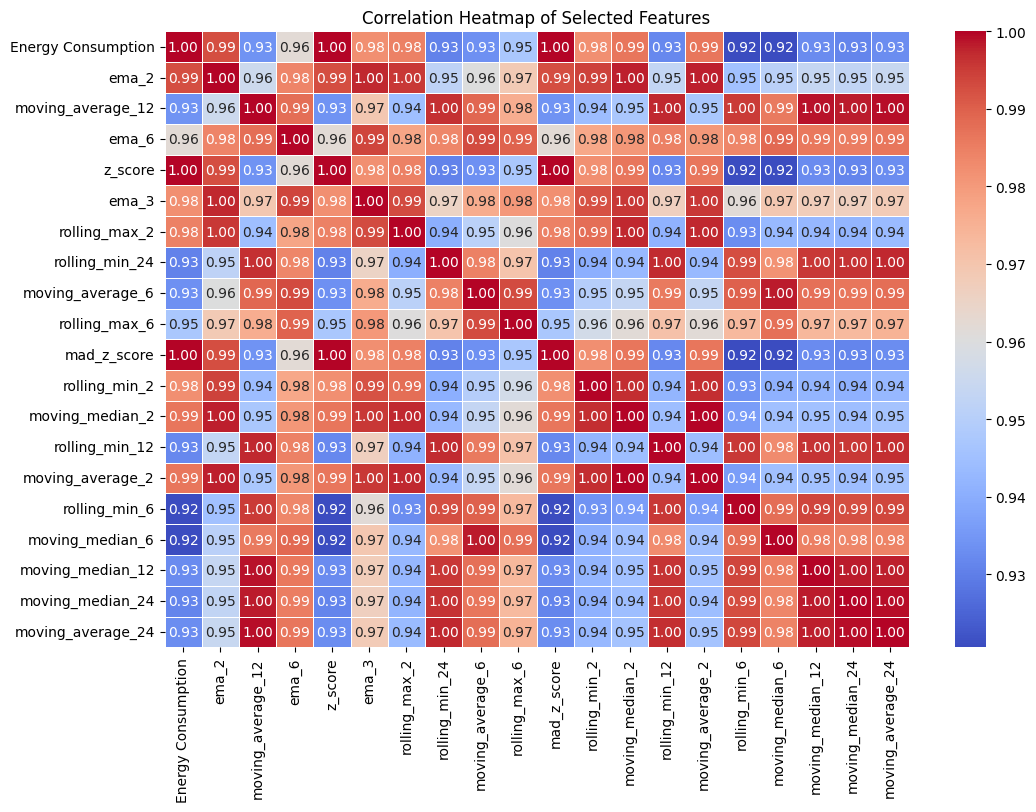

In [11]:
# Calculate and rank features
scores = feature_metrics(features_scaled, scaled_target)
df_scores = pd.DataFrame(scores)
top_n = 20  # Change this to the desired value

# Get ranked scores and top features index
df_scores_ranked, top_features_index = rank_and_top_features(df_scores, top_n=top_n)

# Assuming the features are stored in a DataFrame named 'data_df_drop' with 'Time' as the index
top_features_index_names = data_df_drop.columns[top_features_index]

print(f"\nTop {top_n} Features Index:")
print(top_features_index_names)

# Extract the top features from the original DataFrame
selected_features_df = data_df_drop[top_features_index_names]

correlation_matrix = selected_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

extracted_features_data = selected_features_df.to_numpy()

In [12]:
def prepare_time_series_data(data, time_steps=12, test_size=0.2, random_state=42):
    """
    Prepare time series data for training and testing.

    Parameters:
    - data: The time series data.
    - time_steps: Number of time steps to consider for each sample.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.

    Returns:
    - x_train, x_test, y_train, y_test: Prepared training and testing sets.
    """
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)

    total_samples, num_features = data_scaled.shape
    n_steps = time_steps

    X = []
    y = []

    for i in range(n_steps, len(data_scaled)):
        X.append(data_scaled[i - n_steps:i, :])
        y.append(data_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    return X, y, x_train, x_test, y_train, y_test

# Example usage:
time_steps = 12
X, y, x_train, x_test, y_train, y_test = prepare_time_series_data(extracted_features_data, time_steps)

print("Training set shapes:")
print(x_train.shape, y_train.shape)

print("\nTesting set shapes:")
print(x_test.shape, y_test.shape)

Training set shapes:
(451, 12, 20) (451,)

Testing set shapes:
(113, 12, 20) (113,)


In [13]:
# Assuming x_train, x_test, y_train, y_test are already prepared
# Using the same shapes you provided (12 time steps, 20 features)

import tensorflow.keras.backend as K

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dense(units=25, activation='relu'))  # Output layer with 1 neuron for regression tasks
model_lstm.add(Dense(units=1))  # Output layer with 1 neuron for regression tasks

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model_lstm.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath1 = 'best_model_lstm.h5'
model_checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint1]
)

Epoch 1/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - loss: 0.7739 - mae: 0.7232 - r_squared: -64.1798
Epoch 1: val_loss improved from inf to 0.21763, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - loss: 0.6438 - mae: 0.6365 - r_squared: -69.1726 - val_loss: 0.2176 - val_mae: 0.4026 - val_r_squared: -72.2802
Epoch 2/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2182 - mae: 0.4060 - r_squared: -114.5664
Epoch 2: val_loss improved from 0.21763 to 0.20368, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1881 - mae: 0.3635 - r_squared: -120.8814 - val_loss: 0.2037 - val_mae: 0.3589 - val_r_squared: -93.2299
Epoch 3/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2024 - mae: 0.3694 - r_squared: -154.8063
Epoch 3: val_loss improved from 0.20368 to 0.19067, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1811 - mae: 0.3435 - r_squared: -136.3602 - val_loss: 0.1907 - val_mae: 0.3108 - val_r_squared: -72.0123
Epoch 4/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1175 - mae: 0.2661 - r_squared: -112.4445
Epoch 4: val_loss improved from 0.19067 to 0.16770, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1461 - mae: 0.2925 - r_squared: -106.6036 - val_loss: 0.1677 - val_mae: 0.3298 - val_r_squared: -72.5630
Epoch 5/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1216 - mae: 0.2674 - r_squared: -113.7416
Epoch 5: val_loss improved from 0.16770 to 0.15002, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1482 - mae: 0.3095 - r_squared: -110.1884 - val_loss: 0.1500 - val_mae: 0.3048 - val_r_squared: -76.4100
Epoch 6/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1192 - mae: 0.2834 - r_squared: -120.3611
Epoch 6: val_loss did not improve from 0.15002
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1294 - mae: 0.2845 - r_squared: -115.1277 - val_loss: 0.1540 - val_mae: 0.2887 - val_r_squared: -78.4080
Epoch 7/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1032 - mae: 0.2605 - r_squared: -121.8132
Epoch 7: val_loss improved from 0.15002 to 0.13296, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1217 - mae: 0.2772 - r_squared: -118.6827 - val_loss: 0.1330 - val_mae: 0.2804 - val_r_squared: -80.4483
Epoch 8/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1889 - mae: 0.3611 - r_squared: -112.8488
Epoch 8: val_loss improved from 0.13296 to 0.13169, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1376 - mae: 0.2999 - r_squared: -116.9307 - val_loss: 0.1317 - val_mae: 0.2791 - val_r_squared: -77.0120
Epoch 9/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1031 - mae: 0.2560 - r_squared: -121.2071
Epoch 9: val_loss improved from 0.13169 to 0.11526, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1135 - mae: 0.2676 - r_squared: -113.0964 - val_loss: 0.1153 - val_mae: 0.2729 - val_r_squared: -79.2917
Epoch 10/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0997 - mae: 0.2554 - r_squared: -126.5233
Epoch 10: val_loss improved from 0.11526 to 0.10702, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1055 - mae: 0.2632 - r_squared: -117.6852 - val_loss: 0.1070 - val_mae: 0.2597 - val_r_squared: -80.5492
Epoch 11/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1041 - mae: 0.2683 - r_squared: -118.1218
Epoch 11: val_loss did not improve from 0.10702
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1043 - mae: 0.2703 - r_squared: -121.4355 - val_loss: 0.1119 - val_mae: 0.2555 - val_r_squared: -77.9162
Epoch 12/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1050 - mae: 0.2645 - r_squared: -115.5143
Epoch 12: val_loss improved from 0.10702 to 0.08787, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1013 - mae: 0.2568 - r_squared: -113.4675 - val_loss: 0.0879 - val_mae: 0.2419 - val_r_squared: -81.6421
Epoch 13/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0880 - mae: 0.2509 - r_squared: -129.0011
Epoch 13: val_loss improved from 0.08787 to 0.07434, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0880 - mae: 0.2498 - r_squared: -120.4152 - val_loss: 0.0743 - val_mae: 0.2250 - val_r_squared: -83.6953
Epoch 14/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0892 - mae: 0.2639 - r_squared: -114.9017
Epoch 14: val_loss improved from 0.07434 to 0.06716, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0833 - mae: 0.2440 - r_squared: -118.1662 - val_loss: 0.0672 - val_mae: 0.2134 - val_r_squared: -88.5590
Epoch 15/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0645 - mae: 0.2048 - r_squared: -127.7642
Epoch 15: val_loss improved from 0.06716 to 0.06581, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0720 - mae: 0.2243 - r_squared: -122.9542 - val_loss: 0.0658 - val_mae: 0.2072 - val_r_squared: -81.0204
Epoch 16/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0678 - mae: 0.2149 - r_squared: -122.5973
Epoch 16: val_loss did not improve from 0.06581
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0696 - mae: 0.2220 - r_squared: -121.2298 - val_loss: 0.0737 - val_mae: 0.2178 - val_r_squared: -78.6052
Epoch 17/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0751 - mae: 0.2194 - r_squared: -113.0452
Epoch 17: val_loss improved from 0.06581 to 0.05675, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0716 - mae: 0.2168 - r_squared: -118.3950 - val_loss: 0.0567 - val_mae: 0.1896 - val_r_squared: -82.3387
Epoch 18/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0619 - mae: 0.2076 - r_squared: -118.8172
Epoch 18: val_loss improved from 0.05675 to 0.05245, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0647 - mae: 0.2095 - r_squared: -118.5447 - val_loss: 0.0524 - val_mae: 0.1833 - val_r_squared: -82.9823
Epoch 19/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0577 - mae: 0.1939 - r_squared: -125.0158
Epoch 19: val_loss improved from 0.05245 to 0.04876, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0615 - mae: 0.2041 - r_squared: -118.9915 - val_loss: 0.0488 - val_mae: 0.1786 - val_r_squared: -85.8576
Epoch 20/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0656 - mae: 0.2192 - r_squared: -123.5904
Epoch 20: val_loss did not improve from 0.04876
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0656 - mae: 0.2093 - r_squared: -116.3610 - val_loss: 0.0613 - val_mae: 0.2034 - val_r_squared: -83.9535
Epoch 21/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0648 - mae: 0.2096 - r_squared: -126.4925
Epoch 21: val_loss did not improve from 0.04876
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0668 - mae: 0.2148 - r_squared: -123.7419 - val_loss: 0.0541 - val_mae: 0.1892 - val_r_squared: -83.2146
Epoch 22/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0555 - mae: 0.1899 - r_squared: -120.1144
Epoch 22: val_loss did not improve from 0.04876
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0604 - mae: 0.2009 - r_squared: -120.052

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0563 - mae: 0.1945 - r_squared: -118.7628 - val_loss: 0.0483 - val_mae: 0.1778 - val_r_squared: -83.6626
Epoch 25/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0484 - mae: 0.1848 - r_squared: -128.2745
Epoch 25: val_loss did not improve from 0.04828
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0530 - mae: 0.1907 - r_squared: -120.8017 - val_loss: 0.0808 - val_mae: 0.2280 - val_r_squared: -99.3730
Epoch 26/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0922 - mae: 0.2455 - r_squared: -141.9457
Epoch 26: val_loss did not improve from 0.04828
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0773 - mae: 0.2252 - r_squared: -127.5732 - val_loss: 0.0655 - val_mae: 0.2047 - val_r_squared: -79.9751
Epoch 27/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0575 - mae: 0.1920 - r_squared: -116.0975
Epoch 27: val_loss did not improve from 0.04828
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0690 - mae: 0.2186 - r_squared: -120.592

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0614 - mae: 0.2042 - r_squared: -114.5754 - val_loss: 0.0459 - val_mae: 0.1680 - val_r_squared: -85.6186
Epoch 29/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0568 - mae: 0.1992 - r_squared: -121.2171
Epoch 29: val_loss improved from 0.04589 to 0.04379, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0570 - mae: 0.1991 - r_squared: -120.9329 - val_loss: 0.0438 - val_mae: 0.1653 - val_r_squared: -83.8871
Epoch 30/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0523 - mae: 0.1920 - r_squared: -120.8523
Epoch 30: val_loss improved from 0.04379 to 0.04061, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0498 - mae: 0.1847 - r_squared: -120.5505 - val_loss: 0.0406 - val_mae: 0.1585 - val_r_squared: -86.4472
Epoch 31/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0512 - mae: 0.1860 - r_squared: -124.4251
Epoch 31: val_loss improved from 0.04061 to 0.04012, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0481 - mae: 0.1821 - r_squared: -123.9012 - val_loss: 0.0401 - val_mae: 0.1641 - val_r_squared: -83.1411
Epoch 32/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0430 - mae: 0.1798 - r_squared: -119.6263
Epoch 32: val_loss did not improve from 0.04012
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0437 - mae: 0.1767 - r_squared: -119.7906 - val_loss: 0.0407 - val_mae: 0.1648 - val_r_squared: -83.9764
Epoch 33/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0524 - mae: 0.1957 - r_squared: -122.2819
Epoch 33: val_loss did not improve from 0.04012
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0460 - mae: 0.1812 - r_squared: -120.2027 - val_loss: 0.0555 - val_mae: 0.1922 - val_r_squared: -81.1131
Epoch 34/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0524 - mae: 0.1944 - r_squared: -118.7986
Epoch 34: val_loss did not improve from 0.04012
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0488 - mae: 0.1866 - r_squared: -120.571

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0453 - mae: 0.1785 - r_squared: -116.5519 - val_loss: 0.0387 - val_mae: 0.1584 - val_r_squared: -89.7574
Epoch 36/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0432 - mae: 0.1725 - r_squared: -122.0665
Epoch 36: val_loss did not improve from 0.03874
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0429 - mae: 0.1717 - r_squared: -122.2665 - val_loss: 0.0411 - val_mae: 0.1677 - val_r_squared: -81.3572
Epoch 37/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0374 - mae: 0.1536 - r_squared: -117.2231
Epoch 37: val_loss improved from 0.03874 to 0.03530, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0393 - mae: 0.1626 - r_squared: -120.4417 - val_loss: 0.0353 - val_mae: 0.1520 - val_r_squared: -85.4725
Epoch 38/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0324 - mae: 0.1429 - r_squared: -126.0343
Epoch 38: val_loss improved from 0.03530 to 0.03503, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0361 - mae: 0.1568 - r_squared: -121.1935 - val_loss: 0.0350 - val_mae: 0.1521 - val_r_squared: -87.6395
Epoch 39/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0403 - mae: 0.1627 - r_squared: -132.6089
Epoch 39: val_loss did not improve from 0.03503
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0369 - mae: 0.1581 - r_squared: -122.6165 - val_loss: 0.0362 - val_mae: 0.1538 - val_r_squared: -91.2459
Epoch 40/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0426 - mae: 0.1654 - r_squared: -131.5427
Epoch 40: val_loss improved from 0.03503 to 0.03336, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0410 - mae: 0.1650 - r_squared: -122.9702 - val_loss: 0.0334 - val_mae: 0.1492 - val_r_squared: -89.6360
Epoch 41/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0338 - mae: 0.1515 - r_squared: -129.1987
Epoch 41: val_loss did not improve from 0.03336
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0366 - mae: 0.1595 - r_squared: -124.8712 - val_loss: 0.0468 - val_mae: 0.1763 - val_r_squared: -82.0282
Epoch 42/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0378 - mae: 0.1652 - r_squared: -119.4903
Epoch 42: val_loss improved from 0.03336 to 0.03163, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0339 - mae: 0.1540 - r_squared: -120.7601 - val_loss: 0.0316 - val_mae: 0.1461 - val_r_squared: -86.5356
Epoch 43/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0390 - mae: 0.1616 - r_squared: -128.1707
Epoch 43: val_loss did not improve from 0.03163
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0348 - mae: 0.1546 - r_squared: -121.0210 - val_loss: 0.0320 - val_mae: 0.1451 - val_r_squared: -90.3579
Epoch 44/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0322 - mae: 0.1521 - r_squared: -132.0219
Epoch 44: val_loss did not improve from 0.03163
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0329 - mae: 0.1501 - r_squared: -124.4935 - val_loss: 0.0417 - val_mae: 0.1709 - val_r_squared: -86.5039
Epoch 45/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0270 - mae: 0.1351 - r_squared: -122.6407
Epoch 45: val_loss did not improve from 0.03163
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0318 - mae: 0.1465 - r_squared: -122.58

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0302 - mae: 0.1419 - r_squared: -121.4002 - val_loss: 0.0294 - val_mae: 0.1407 - val_r_squared: -86.9475
Epoch 47/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0252 - mae: 0.1301 - r_squared: -127.5125
Epoch 47: val_loss did not improve from 0.02943
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0308 - mae: 0.1447 - r_squared: -121.4668 - val_loss: 0.0314 - val_mae: 0.1439 - val_r_squared: -92.7134
Epoch 48/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0300 - mae: 0.1479 - r_squared: -132.4096
Epoch 48: val_loss did not improve from 0.02943
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0325 - mae: 0.1502 - r_squared: -125.3747 - val_loss: 0.0307 - val_mae: 0.1457 - val_r_squared: -89.1773
Epoch 49/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0288 - mae: 0.1416 - r_squared: -130.2878
Epoch 49: val_loss did not improve from 0.02943
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0289 - mae: 0.1402 - r_squared: -124.905

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0282 - mae: 0.1395 - r_squared: -123.7533 - val_loss: 0.0272 - val_mae: 0.1358 - val_r_squared: -91.0118
Epoch 52/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0289 - mae: 0.1439 - r_squared: -129.0674
Epoch 52: val_loss improved from 0.02722 to 0.02665, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0285 - mae: 0.1408 - r_squared: -125.2358 - val_loss: 0.0266 - val_mae: 0.1313 - val_r_squared: -87.0573
Epoch 53/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0264 - mae: 0.1318 - r_squared: -125.8920
Epoch 53: val_loss did not improve from 0.02665
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0258 - mae: 0.1298 - r_squared: -124.4593 - val_loss: 0.0285 - val_mae: 0.1362 - val_r_squared: -85.1324
Epoch 54/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0186 - mae: 0.1138 - r_squared: -119.5589
Epoch 54: val_loss did not improve from 0.02665
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0226 - mae: 0.1221 - r_squared: -122.2006 - val_loss: 0.0280 - val_mae: 0.1380 - val_r_squared: -87.3124
Epoch 55/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0224 - mae: 0.1153 - r_squared: -126.3615
Epoch 55: val_loss improved from 0.02665 to 0.02507, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0225 - mae: 0.1191 - r_squared: -122.6805 - val_loss: 0.0251 - val_mae: 0.1295 - val_r_squared: -89.0618
Epoch 56/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0245 - mae: 0.1297 - r_squared: -124.0987
Epoch 56: val_loss did not improve from 0.02507
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0246 - mae: 0.1285 - r_squared: -122.4488 - val_loss: 0.0282 - val_mae: 0.1375 - val_r_squared: -84.0386
Epoch 57/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0249 - mae: 0.1353 - r_squared: -117.9497
Epoch 57: val_loss did not improve from 0.02507
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0232 - mae: 0.1257 - r_squared: -121.2596 - val_loss: 0.0367 - val_mae: 0.1561 - val_r_squared: -85.0578
Epoch 58/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0219 - mae: 0.1199 - r_squared: -119.1047
Epoch 58: val_loss did not improve from 0.02507
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0235 - mae: 0.1237 - r_squared: -119.931

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0220 - mae: 0.1206 - r_squared: -122.0337 - val_loss: 0.0226 - val_mae: 0.1243 - val_r_squared: -89.9955
Epoch 63/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0176 - mae: 0.1054 - r_squared: -127.9601
Epoch 63: val_loss did not improve from 0.02261
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0197 - mae: 0.1128 - r_squared: -123.5724 - val_loss: 0.0231 - val_mae: 0.1216 - val_r_squared: -88.7767
Epoch 64/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0297 - mae: 0.1340 - r_squared: -123.7526
Epoch 64: val_loss did not improve from 0.02261
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0250 - mae: 0.1268 - r_squared: -123.8351 - val_loss: 0.0294 - val_mae: 0.1376 - val_r_squared: -85.4155
Epoch 65/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0202 - mae: 0.1144 - r_squared: -121.4800
Epoch 65: val_loss did not improve from 0.02261
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0194 - mae: 0.1120 - r_squared: -121.402

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0220 - mae: 0.1204 - r_squared: -124.1668 - val_loss: 0.0225 - val_mae: 0.1205 - val_r_squared: -87.5060
Epoch 67/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0196 - mae: 0.1135 - r_squared: -123.7442
Epoch 67: val_loss improved from 0.02250 to 0.02142, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0204 - mae: 0.1159 - r_squared: -123.3091 - val_loss: 0.0214 - val_mae: 0.1188 - val_r_squared: -89.9883
Epoch 68/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0197 - mae: 0.1139 - r_squared: -126.1168
Epoch 68: val_loss did not improve from 0.02142
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0229 - mae: 0.1216 - r_squared: -123.1032 - val_loss: 0.0265 - val_mae: 0.1343 - val_r_squared: -89.7221
Epoch 69/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0152 - mae: 0.1052 - r_squared: -126.6883
Epoch 69: val_loss did not improve from 0.02142
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0183 - mae: 0.1120 - r_squared: -124.2596 - val_loss: 0.0303 - val_mae: 0.1389 - val_r_squared: -85.4512
Epoch 70/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0192 - mae: 0.1055 - r_squared: -119.6387
Epoch 70: val_loss did not improve from 0.02142
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0220 - mae: 0.1157 - r_squared: -119.730

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0165 - mae: 0.1026 - r_squared: -123.4272 - val_loss: 0.0208 - val_mae: 0.1158 - val_r_squared: -89.7328
Epoch 77/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0135 - mae: 0.0934 - r_squared: -128.2385
Epoch 77: val_loss did not improve from 0.02084
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0170 - mae: 0.1043 - r_squared: -122.9637 - val_loss: 0.0210 - val_mae: 0.1166 - val_r_squared: -90.6161
Epoch 78/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0156 - mae: 0.1018 - r_squared: -126.6415
Epoch 78: val_loss did not improve from 0.02084
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0159 - mae: 0.1003 - r_squared: -124.3260 - val_loss: 0.0210 - val_mae: 0.1158 - val_r_squared: -88.3822
Epoch 79/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0125 - mae: 0.0935 - r_squared: -124.3163
Epoch 79: val_loss improved from 0.02084 to 0.02059, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0159 - mae: 0.1015 - r_squared: -124.3235 - val_loss: 0.0206 - val_mae: 0.1145 - val_r_squared: -86.8623
Epoch 80/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0152 - mae: 0.0986 - r_squared: -120.7324
Epoch 80: val_loss did not improve from 0.02059
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0156 - mae: 0.1000 - r_squared: -122.9040 - val_loss: 0.0240 - val_mae: 0.1237 - val_r_squared: -88.5681
Epoch 81/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0153 - mae: 0.0996 - r_squared: -123.2647
Epoch 81: val_loss did not improve from 0.02059
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0156 - mae: 0.1000 - r_squared: -122.3220 - val_loss: 0.0231 - val_mae: 0.1240 - val_r_squared: -89.4962
Epoch 82/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0114 - mae: 0.0890 - r_squared: -126.9278
Epoch 82: val_loss did not improve from 0.02059
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0148 - mae: 0.0986 - r_squared: -123.633

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0168 - mae: 0.1020 - r_squared: -123.2994 - val_loss: 0.0196 - val_mae: 0.1140 - val_r_squared: -88.5962
Epoch 86/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0124 - mae: 0.0860 - r_squared: -127.3180
Epoch 86: val_loss did not improve from 0.01957
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0146 - mae: 0.0955 - r_squared: -123.5993 - val_loss: 0.0203 - val_mae: 0.1160 - val_r_squared: -91.5526
Epoch 87/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0154 - mae: 0.1040 - r_squared: -132.3412
Epoch 87: val_loss improved from 0.01957 to 0.01933, saving model to best_model_lstm.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0151 - mae: 0.0996 - r_squared: -124.4276 - val_loss: 0.0193 - val_mae: 0.1113 - val_r_squared: -89.8439
Epoch 88/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0172 - mae: 0.1007 - r_squared: -126.4643
Epoch 88: val_loss did not improve from 0.01933
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0144 - mae: 0.0943 - r_squared: -124.3217 - val_loss: 0.0210 - val_mae: 0.1154 - val_r_squared: -89.8765
Epoch 89/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0127 - mae: 0.0874 - r_squared: -125.8204
Epoch 89: val_loss did not improve from 0.01933
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0148 - mae: 0.0939 - r_squared: -125.0243 - val_loss: 0.0291 - val_mae: 0.1316 - val_r_squared: -84.7790
Epoch 90/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0131 - mae: 0.0912 - r_squared: -121.2041
Epoch 90: val_loss did not improve from 0.01933
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0164 - mae: 0.1019 - r_squared: -120.722

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0163 - mae: 0.0993 - r_squared: -121.3209 - val_loss: 0.0187 - val_mae: 0.1097 - val_r_squared: -89.3870
Epoch 95/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0121 - mae: 0.0876 - r_squared: -128.2530
Epoch 95: val_loss did not improve from 0.01868
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0133 - mae: 0.0913 - r_squared: -122.8050 - val_loss: 0.0209 - val_mae: 0.1168 - val_r_squared: -92.8726
Epoch 96/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0142 - mae: 0.0916 - r_squared: -130.6505
Epoch 96: val_loss did not improve from 0.01868
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0146 - mae: 0.0957 - r_squared: -125.9624 - val_loss: 0.0196 - val_mae: 0.1123 - val_r_squared: -89.4701
Epoch 97/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0094 - mae: 0.0786 - r_squared: -129.7683
Epoch 97: val_loss did not improve from 0.01868
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0116 - mae: 0.0852 - r_squared: -125.639

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0139 - mae: 0.0927 - r_squared: -125.1786 - val_loss: 0.0177 - val_mae: 0.1067 - val_r_squared: -89.6019
Epoch 101/200
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0137 - mae: 0.0922 - r_squared: -125.0158
Epoch 101: val_loss did not improve from 0.01768
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0141 - mae: 0.0931 - r_squared: -122.6534 - val_loss: 0.0185 - val_mae: 0.1097 - val_r_squared: -90.7318
Epoch 102/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0095 - mae: 0.0736 - r_squared: -126.9058
Epoch 102: val_loss did not improve from 0.01768
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0114 - mae: 0.0819 - r_squared: -125.1832 - val_loss: 0.0205 - val_mae: 0.1138 - val_r_squared: -86.3689
Epoch 103/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0141 - mae: 0.0940 - r_squared: -121.5180
Epoch 103: val_loss did not improve from 0.01768
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0125 - mae: 0.0892 - r_squared: -1

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0106 - mae: 0.0804 - r_squared: -126.1704 - val_loss: 0.0174 - val_mae: 0.1052 - val_r_squared: -89.9391
Epoch 122/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0072 - mae: 0.0662 - r_squared: -126.6259
Epoch 122: val_loss did not improve from 0.01742
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0101 - mae: 0.0772 - r_squared: -125.4545 - val_loss: 0.0193 - val_mae: 0.1111 - val_r_squared: -87.2678
Epoch 123/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0098 - mae: 0.0768 - r_squared: -121.4532
Epoch 123: val_loss did not improve from 0.01742
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0102 - mae: 0.0773 - r_squared: -122.7515 - val_loss: 0.0176 - val_mae: 0.1058 - val_r_squared: -89.1166
Epoch 124/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0065 - mae: 0.0653 - r_squared: -124.5763
Epoch 124: val_loss did not improve from 0.01742
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0094 - mae: 0.0754 - r_squared: -1

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0097 - mae: 0.0759 - r_squared: -125.6320 - val_loss: 0.0170 - val_mae: 0.1028 - val_r_squared: -90.3459
Epoch 142/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0067 - mae: 0.0701 - r_squared: -126.7524
Epoch 142: val_loss did not improve from 0.01696
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0108 - mae: 0.0803 - r_squared: -125.0779 - val_loss: 0.0177 - val_mae: 0.1057 - val_r_squared: -91.1047
Epoch 143/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0082 - mae: 0.0731 - r_squared: -132.1340
Epoch 143: val_loss did not improve from 0.01696
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0105 - mae: 0.0792 - r_squared: -127.3486 - val_loss: 0.0185 - val_mae: 0.1070 - val_r_squared: -89.4562
Epoch 144/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0084 - mae: 0.0690 - r_squared: -130.1216
Epoch 144: val_loss did not improve from 0.01696
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0103 - mae: 0.0770 - r_squared: -1

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0088 - mae: 0.0735 - r_squared: -125.7086 - val_loss: 0.0166 - val_mae: 0.1043 - val_r_squared: -89.6456
Epoch 154/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0080 - mae: 0.0701 - r_squared: -125.7453
Epoch 154: val_loss did not improve from 0.01658
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0093 - mae: 0.0741 - r_squared: -124.3873 - val_loss: 0.0188 - val_mae: 0.1072 - val_r_squared: -91.8300
Epoch 155/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0132 - mae: 0.0905 - r_squared: -129.8623
Epoch 155: val_loss did not improve from 0.01658
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0131 - mae: 0.0888 - r_squared: -126.4698 - val_loss: 0.0197 - val_mae: 0.1126 - val_r_squared: -90.2149
Epoch 156/200
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0071 - mae: 0.0613 - r_squared: -127.6539
Epoch 156: val_loss did not improve from 0.01658
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0100 - mae: 0.0740 - r_squared: -1

In [14]:
def positional_embedding(inputs, name="positional_embedding"):
    # Get the length of the input sequence
    input_seq_len = inputs.shape[1]

    # Create positional embeddings using an Embedding layer
    # The output dimension is set to the last dimension of the input
    position_embed = layers.Embedding(input_dim=input_seq_len, output_dim=inputs.shape[-1], name=name)(tf.range(input_seq_len))

    # Add positional embeddings to the input
    return inputs + position_embed

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization for input sequence
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head self-attention mechanism
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Residual connection: add the original input to the output of attention mechanism
    res = x + inputs

    # Layer normalization for the residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part:
    # Convolutional layer with a ReLU activation function
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Convolutional layer with the same number of filters as the input dimension
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    # Add the output of the feed-forward part to the residual connection
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):

    # Define the input layer with the specified input shape
    inputs = keras.Input(shape = input_shape)

    # Add positional embedding to the input sequence
    x = positional_embedding(inputs)

    # Loop through the specified number of transformer blocks
    for _ in range(num_transformer_blocks):
        # Apply transformer_encoder function to the input sequence
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Loop through the specified MLP (Multi-Layer Perceptron) units
    for dim in mlp_units:
        # Fully connected layer with ReLU activation function
        x = layers.Dense(dim, activation="relu")(x)

        # Apply dropout for regularization
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer with a single neuron (regression task)
    outputs = layers.Dense(1)(x)

    # Create a Keras Model with the defined input and output layers
    return keras.Model(inputs, outputs)

In [15]:
input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=16,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[256],
#     mlp_dropout=0.2,
#     dropout=0.2,
# )


model = build_model(
    input_shape,
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.2,
)

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath2 = 'best_model_transformer.h5'
model_checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint2]
)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.3628 - mae: 0.4677 - r_squared: -88.7992
Epoch 1: val_loss improved from inf to 0.16178, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 45s 744ms/step - loss: 0.3518 - mae: 0.4602 - r_squared: -89.7453 - val_loss: 0.1618 - val_mae: 0.3321 - val_r_squared: -93.9641
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2002 - mae: 0.3613 - r_squared: -144.3555
Epoch 2: val_loss did not improve from 0.16178
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.1988 - mae: 0.3600 - r_squared: -142.0877 - val_loss: 0.1761 - val_mae: 0.3105 - val_r_squared: -70.6298
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1406 - mae: 0.2851 - r_squared: -106.9656
Epoch 3: val_loss improved from 0.16178 to 0.12760, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.1404 - mae: 0.2856 - r_squared: -106.2896 - val_loss: 0.1276 - val_mae: 0.2614 - val_r_squared: -77.2329
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1484 - mae: 0.3067 - r_squared: -121.6780
Epoch 4: val_loss improved from 0.12760 to 0.10792, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.1479 - mae: 0.3065 - r_squared: -120.7180 - val_loss: 0.1079 - val_mae: 0.2451 - val_r_squared: -81.4822
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1328 - mae: 0.2931 - r_squared: -120.9495
Epoch 5: val_loss improved from 0.10792 to 0.09570, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 0.1313 - mae: 0.2914 - r_squared: -119.8181 - val_loss: 0.0957 - val_mae: 0.2346 - val_r_squared: -76.8970
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0943 - mae: 0.2436 - r_squared: -118.3530
Epoch 6: val_loss improved from 0.09570 to 0.06803, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0948 - mae: 0.2434 - r_squared: -117.2892 - val_loss: 0.0680 - val_mae: 0.1980 - val_r_squared: -83.9264
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0796 - mae: 0.2249 - r_squared: -123.1514
Epoch 7: val_loss improved from 0.06803 to 0.05862, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - loss: 0.0800 - mae: 0.2255 - r_squared: -122.4997 - val_loss: 0.0586 - val_mae: 0.1757 - val_r_squared: -82.6907
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0856 - mae: 0.2349 - r_squared: -118.7586 
Epoch 8: val_loss improved from 0.05862 to 0.04416, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 0.0847 - mae: 0.2335 - r_squared: -117.5772 - val_loss: 0.0442 - val_mae: 0.1657 - val_r_squared: -80.4977
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0626 - mae: 0.2022 - r_squared: -121.4239
Epoch 9: val_loss improved from 0.04416 to 0.03604, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0618 - mae: 0.2009 - r_squared: -120.9359 - val_loss: 0.0360 - val_mae: 0.1459 - val_r_squared: -84.2699
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0569 - mae: 0.1893 - r_squared: -121.1668
Epoch 10: val_loss improved from 0.03604 to 0.03256, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0566 - mae: 0.1886 - r_squared: -120.1438 - val_loss: 0.0326 - val_mae: 0.1472 - val_r_squared: -81.5238
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0493 - mae: 0.1767 - r_squared: -120.5085
Epoch 11: val_loss improved from 0.03256 to 0.02429, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 0.0496 - mae: 0.1769 - r_squared: -120.0043 - val_loss: 0.0243 - val_mae: 0.1238 - val_r_squared: -87.0487
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0523 - mae: 0.1834 - r_squared: -124.6943
Epoch 12: val_loss did not improve from 0.02429
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0517 - mae: 0.1820 - r_squared: -123.8210 - val_loss: 0.0253 - val_mae: 0.1262 - val_r_squared: -84.1302
Epoch 13/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0485 - mae: 0.1740 - r_squared: -121.3705
Epoch 13: val_loss did not improve from 0.02429
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0483 - mae: 0.1738 - r_squared: -120.6593 - val_loss: 0.0322 - val_mae: 0.1450 - val_r_squared: -84.9135
Epoch 14/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0475 - mae: 0.1701 - r_squared: -124.8605
Epoch 14: val_loss improved from 0.02429 to 0.02331, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0470 - mae: 0.1695 - r_squared: -123.9320 - val_loss: 0.0233 - val_mae: 0.1209 - val_r_squared: -84.6144
Epoch 15/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0394 - mae: 0.1594 - r_squared: -122.1460
Epoch 15: val_loss improved from 0.02331 to 0.01842, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.0395 - mae: 0.1592 - r_squared: -121.5664 - val_loss: 0.0184 - val_mae: 0.1045 - val_r_squared: -88.3378
Epoch 16/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0420 - mae: 0.1602 - r_squared: -128.2057
Epoch 16: val_loss did not improve from 0.01842
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0417 - mae: 0.1601 - r_squared: -126.8665 - val_loss: 0.0215 - val_mae: 0.1163 - val_r_squared: -84.3713
Epoch 17/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0380 - mae: 0.1514 - r_squared: -124.5227
Epoch 17: val_loss did not improve from 0.01842
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0376 - mae: 0.1505 - r_squared: -123.4594 - val_loss: 0.0203 - val_mae: 0.1120 - val_r_squared: -84.1802
Epoch 18/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0378 - mae: 0.1520 - r_squared: -122.4978
Epoch 18: val_loss improved from 0.01842 to 0.01673, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.0374 - mae: 0.1513 - r_squared: -121.6996 - val_loss: 0.0167 - val_mae: 0.1004 - val_r_squared: -86.4908
Epoch 19/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0353 - mae: 0.1469 - r_squared: -125.5887
Epoch 19: val_loss did not improve from 0.01673
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0352 - mae: 0.1469 - r_squared: -124.6791 - val_loss: 0.0190 - val_mae: 0.1100 - val_r_squared: -85.9846
Epoch 20/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0325 - mae: 0.1391 - r_squared: -123.6266
Epoch 20: val_loss improved from 0.01673 to 0.01603, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.0323 - mae: 0.1388 - r_squared: -122.5842 - val_loss: 0.0160 - val_mae: 0.0987 - val_r_squared: -86.9314
Epoch 21/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0351 - mae: 0.1460 - r_squared: -124.3802
Epoch 21: val_loss improved from 0.01603 to 0.01578, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 0.0350 - mae: 0.1460 - r_squared: -123.6012 - val_loss: 0.0158 - val_mae: 0.0955 - val_r_squared: -89.7846
Epoch 22/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0327 - mae: 0.1424 - r_squared: -127.6138
Epoch 22: val_loss did not improve from 0.01578
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0331 - mae: 0.1433 - r_squared: -126.6188 - val_loss: 0.0234 - val_mae: 0.1245 - val_r_squared: -83.9296
Epoch 23/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0330 - mae: 0.1424 - r_squared: -120.7706
Epoch 23: val_loss did not improve from 0.01578
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0329 - mae: 0.1420 - r_squared: -119.9200 - val_loss: 0.0170 - val_mae: 0.1038 - val_r_squared: -85.5838
Epoch 24/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0278 - mae: 0.1313 - r_squared: -125.6867
Epoch 24: val_loss improved from 0.01578 to 0.01573, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.0281 - mae: 0.1322 - r_squared: -124.6461 - val_loss: 0.0157 - val_mae: 0.0977 - val_r_squared: -88.7171
Epoch 25/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0297 - mae: 0.1374 - r_squared: -127.9154
Epoch 25: val_loss did not improve from 0.01573
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0298 - mae: 0.1378 - r_squared: -126.7357 - val_loss: 0.0190 - val_mae: 0.1092 - val_r_squared: -84.6616
Epoch 26/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0320 - mae: 0.1404 - r_squared: -121.5027
Epoch 26: val_loss improved from 0.01573 to 0.01475, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 0.0316 - mae: 0.1391 - r_squared: -120.7570 - val_loss: 0.0147 - val_mae: 0.0979 - val_r_squared: -85.7485
Epoch 27/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0285 - mae: 0.1352 - r_squared: -122.9213
Epoch 27: val_loss improved from 0.01475 to 0.01402, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.0285 - mae: 0.1353 - r_squared: -122.2763 - val_loss: 0.0140 - val_mae: 0.0921 - val_r_squared: -91.2517
Epoch 28/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0332 - mae: 0.1455 - r_squared: -131.0823
Epoch 28: val_loss did not improve from 0.01402
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0329 - mae: 0.1448 - r_squared: -129.5055 - val_loss: 0.0237 - val_mae: 0.1241 - val_r_squared: -83.0477
Epoch 29/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0268 - mae: 0.1290 - r_squared: -121.5824
Epoch 29: val_loss did not improve from 0.01402
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0266 - mae: 0.1285 - r_squared: -120.6713 - val_loss: 0.0144 - val_mae: 0.0950 - val_r_squared: -86.6253
Epoch 30/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0259 - mae: 0.1237 - r_squared: -126.9451
Epoch 30: val_loss did not improve from 0.01402
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0262 - mae: 0.1249 - r_squared: -126.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.0283 - mae: 0.1339 - r_squared: -123.9315 - val_loss: 0.0135 - val_mae: 0.0895 - val_r_squared: -86.8743
Epoch 37/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0234 - mae: 0.1153 - r_squared: -124.5893
Epoch 37: val_loss did not improve from 0.01345
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0232 - mae: 0.1151 - r_squared: -123.6579 - val_loss: 0.0139 - val_mae: 0.0950 - val_r_squared: -85.7564
Epoch 38/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0234 - mae: 0.1194 - r_squared: -125.5948
Epoch 38: val_loss improved from 0.01345 to 0.01255, saving model to best_model_transformer.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0233 - mae: 0.1191 - r_squared: -124.5480 - val_loss: 0.0125 - val_mae: 0.0855 - val_r_squared: -88.2398
Epoch 39/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0246 - mae: 0.1227 - r_squared: -125.2632
Epoch 39: val_loss did not improve from 0.01255
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0245 - mae: 0.1225 - r_squared: -124.3727 - val_loss: 0.0144 - val_mae: 0.0940 - val_r_squared: -86.6225
Epoch 40/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0225 - mae: 0.1161 - r_squared: -125.0343
Epoch 40: val_loss did not improve from 0.01255
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0225 - mae: 0.1160 - r_squared: -123.9702 - val_loss: 0.0140 - val_mae: 0.0914 - val_r_squared: -86.8666
Epoch 41/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0229 - mae: 0.1183 - r_squared: -125.1609
Epoch 41: val_loss did not improve from 0.01255
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0229 - mae: 0.1184 - r_squared: -124.4

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.0215 - mae: 0.1102 - r_squared: -122.9974 - val_loss: 0.0119 - val_mae: 0.0826 - val_r_squared: -88.4326
Epoch 44/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0233 - mae: 0.1170 - r_squared: -125.2630
Epoch 44: val_loss did not improve from 0.01190
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0232 - mae: 0.1166 - r_squared: -124.4248 - val_loss: 0.0119 - val_mae: 0.0857 - val_r_squared: -87.6362
Epoch 45/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0236 - mae: 0.1186 - r_squared: -126.6104
Epoch 45: val_loss did not improve from 0.01190
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0237 - mae: 0.1185 - r_squared: -125.4631 - val_loss: 0.0167 - val_mae: 0.1010 - val_r_squared: -85.7993
Epoch 46/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0233 - mae: 0.1182 - r_squared: -123.2224
Epoch 46: val_loss did not improve from 0.01190
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0231 - mae: 0.1180 - r_squared: -122

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 0.0168 - mae: 0.1030 - r_squared: -122.4856 - val_loss: 0.0114 - val_mae: 0.0803 - val_r_squared: -87.8367
Epoch 60/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0179 - mae: 0.1052 - r_squared: -127.1635
Epoch 60: val_loss did not improve from 0.01139
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0178 - mae: 0.1047 - r_squared: -125.9972 - val_loss: 0.0124 - val_mae: 0.0839 - val_r_squared: -86.8930
Epoch 61/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0174 - mae: 0.1053 - r_squared: -124.5979
Epoch 61: val_loss did not improve from 0.01139
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0177 - mae: 0.1058 - r_squared: -123.6326 - val_loss: 0.0179 - val_mae: 0.1060 - val_r_squared: -88.8703
Epoch 62/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0209 - mae: 0.1162 - r_squared: -124.9170
Epoch 62: val_loss did not improve from 0.01139
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0206 - mae: 0.1152 - r_squared: -123

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 0.0167 - mae: 0.1015 - r_squared: -121.2344 - val_loss: 0.0109 - val_mae: 0.0778 - val_r_squared: -88.4886
Epoch 84/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0144 - mae: 0.0960 - r_squared: -126.6876
Epoch 84: val_loss did not improve from 0.01094
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0147 - mae: 0.0967 - r_squared: -125.7776 - val_loss: 0.0134 - val_mae: 0.0871 - val_r_squared: -88.3203
Epoch 85/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0168 - mae: 0.1023 - r_squared: -123.4556
Epoch 85: val_loss did not improve from 0.01094
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0168 - mae: 0.1024 - r_squared: -122.4335 - val_loss: 0.0119 - val_mae: 0.0863 - val_r_squared: -86.9981
Epoch 86/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0164 - mae: 0.1014 - r_squared: -124.0490
Epoch 86: val_loss did not improve from 0.01094
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0163 - mae: 0.1011 - r_squared: -123

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.0146 - mae: 0.0946 - r_squared: -125.7547 - val_loss: 0.0108 - val_mae: 0.0761 - val_r_squared: -89.3657
Epoch 108/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0159 - mae: 0.0972 - r_squared: -127.1650
Epoch 108: val_loss did not improve from 0.01084
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0159 - mae: 0.0973 - r_squared: -125.6917 - val_loss: 0.0162 - val_mae: 0.1077 - val_r_squared: -84.7143
Epoch 109/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0166 - mae: 0.1042 - r_squared: -124.4788
Epoch 109: val_loss did not improve from 0.01084
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0166 - mae: 0.1043 - r_squared: -123.8036 - val_loss: 0.0132 - val_mae: 0.0866 - val_r_squared: -87.9365
Epoch 110/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0147 - mae: 0.0949 - r_squared: -123.1248
Epoch 110: val_loss did not improve from 0.01084
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0149 - mae: 0.0954 - r_squared

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 0.0126 - mae: 0.0853 - r_squared: -124.9015 - val_loss: 0.0106 - val_mae: 0.0766 - val_r_squared: -88.9628
Epoch 148/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0111 - mae: 0.0825 - r_squared: -125.7881
Epoch 148: val_loss did not improve from 0.01065
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0113 - mae: 0.0830 - r_squared: -124.6683 - val_loss: 0.0143 - val_mae: 0.0898 - val_r_squared: -87.7222
Epoch 149/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0141 - mae: 0.0910 - r_squared: -125.0450
Epoch 149: val_loss did not improve from 0.01065
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0141 - mae: 0.0913 - r_squared: -123.9660 - val_loss: 0.0116 - val_mae: 0.0847 - val_r_squared: -88.0739
Epoch 150/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0124 - mae: 0.0848 - r_squared: -125.4429
Epoch 150: val_loss did not improve from 0.01065
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0123 - mae: 0.0846 - r_squared

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0113 - mae: 0.0842 - r_squared: -120.9147 - val_loss: 0.0104 - val_mae: 0.0764 - val_r_squared: -88.4704
Epoch 152/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0104 - mae: 0.0783 - r_squared: -125.3556
Epoch 152: val_loss did not improve from 0.01037
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0104 - mae: 0.0784 - r_squared: -124.3590 - val_loss: 0.0105 - val_mae: 0.0763 - val_r_squared: -88.8812
Epoch 153/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0120 - mae: 0.0824 - r_squared: -126.0044
Epoch 153: val_loss did not improve from 0.01037
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0119 - mae: 0.0822 - r_squared: -124.9215 - val_loss: 0.0112 - val_mae: 0.0821 - val_r_squared: -87.6996
Epoch 154/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0119 - mae: 0.0851 - r_squared: -125.3992
Epoch 154: val_loss did not improve from 0.01037
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0119 - mae: 0.0852 - r_squared:

In [16]:
def plot_true_vs_predicted(model, x_data, y_true, scaler):
    # Predict using the model and input data
    y_pred = model.predict(x_data)

    # Inverse transform the standardized target variable
    inverse_scaled_y_true = scaler.inverse_transform(y_true.reshape(-1, 1))
    inverse_scaled_y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Plotting True vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.plot(inverse_scaled_y_true, label='True Values')
    plt.plot(inverse_scaled_y_pred, label='Predicted Values', linestyle='--')
    plt.title('True vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return y_pred

# Prepare the last 120 data for prediction
x_final = X[-120:, :, :]
y_final = y[-120:]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


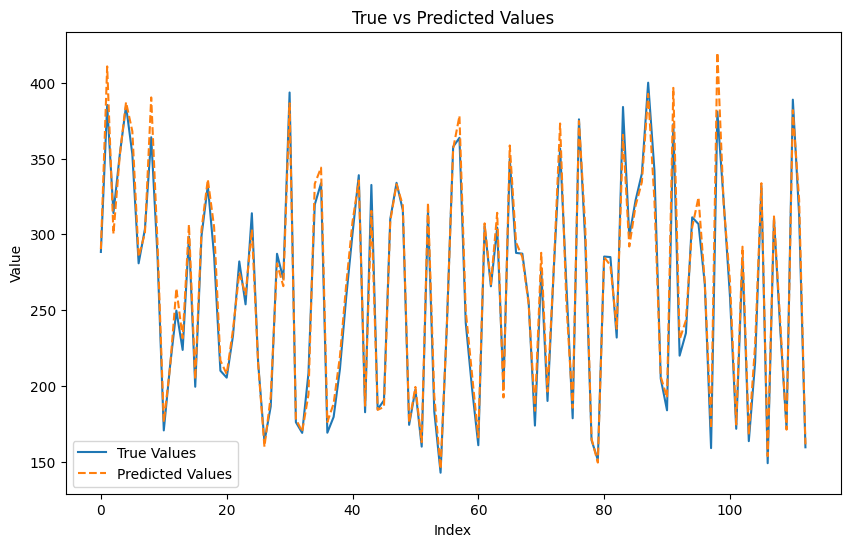

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


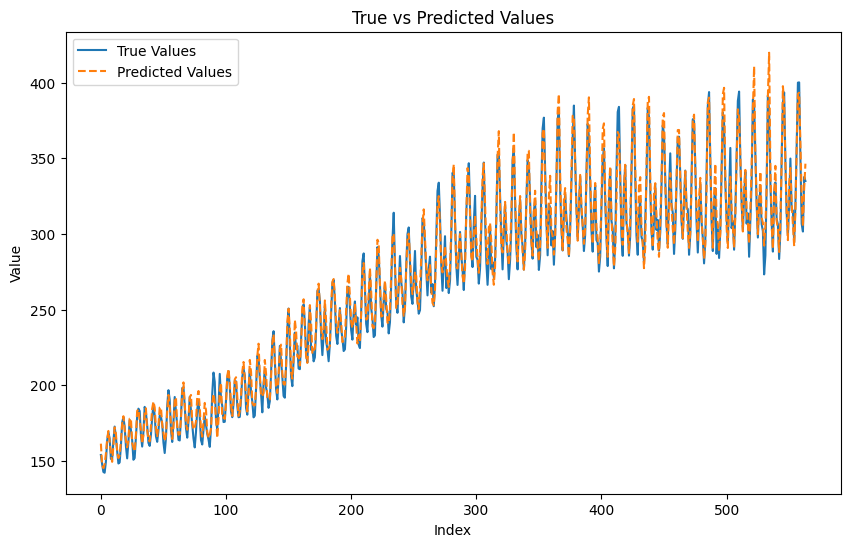

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


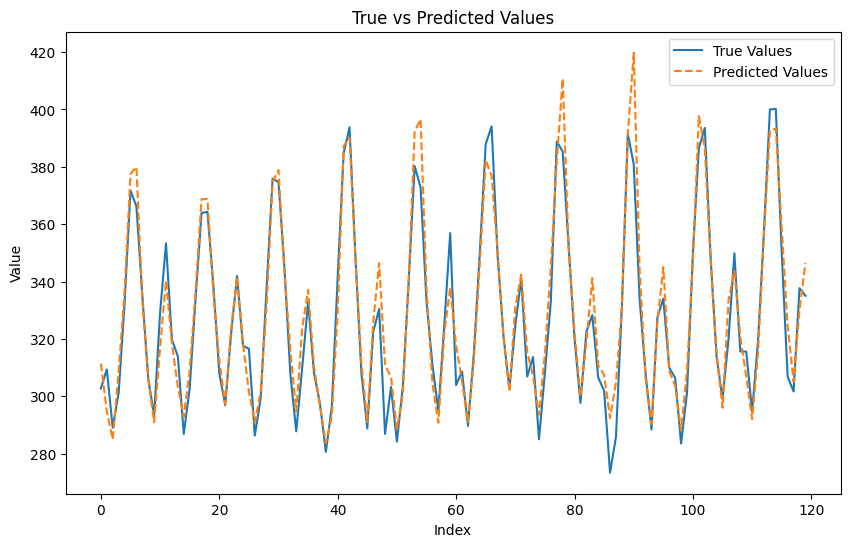

In [17]:
best_model1 = load_model(checkpoint_filepath1, custom_objects={'r_squared': r_squared})
y_test_pred1 = plot_true_vs_predicted(best_model1, x_test, y_test, target_scaler)
y_pred1 = plot_true_vs_predicted(best_model1, X, y, target_scaler)
y_final_pred1 = plot_true_vs_predicted(best_model1, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final1 = target_scaler.inverse_transform(y_final_pred1.reshape(-1, 1))
inverse_scaled_y_Predict1 = target_scaler.inverse_transform(y_pred1.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 697ms/step


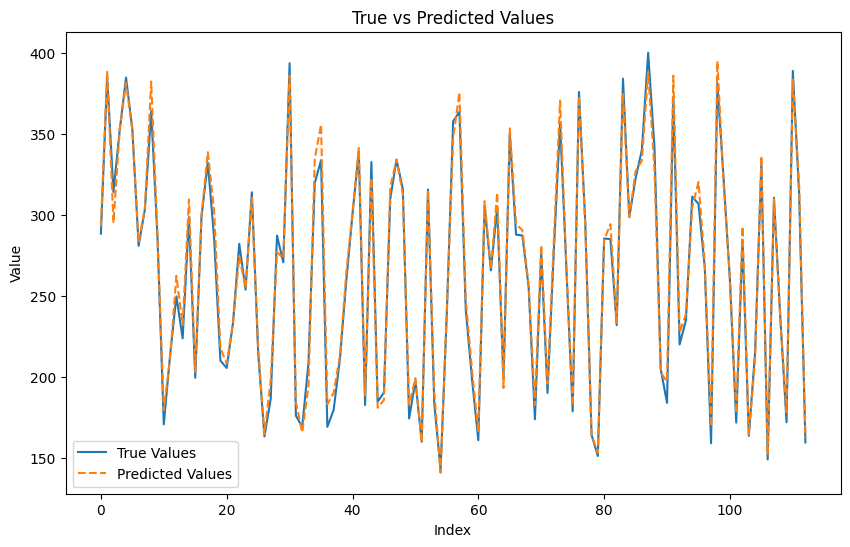

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


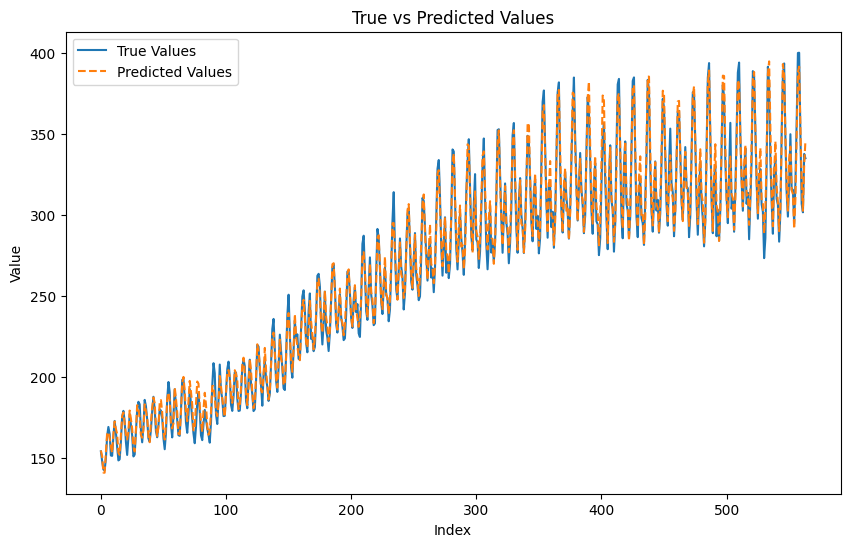

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


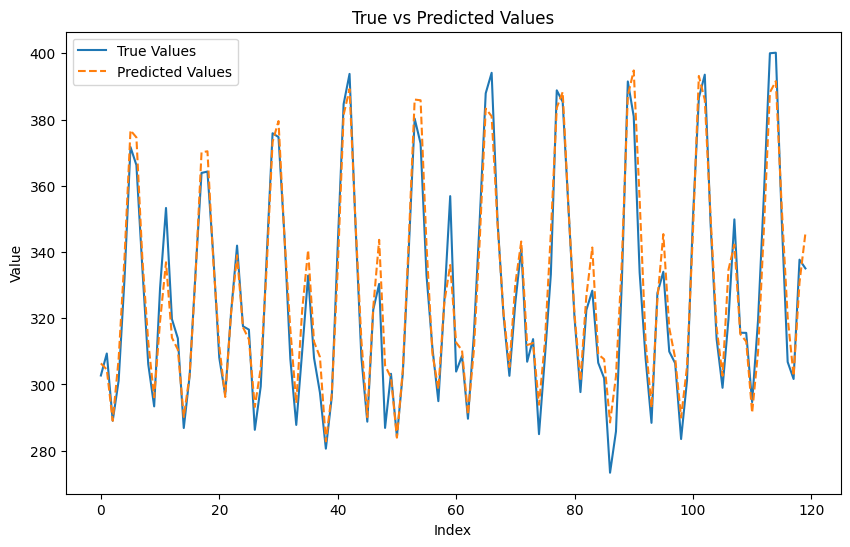

In [18]:
model.save('best_model_transformer.keras')

best_model2 = load_model('best_model_transformer.keras', custom_objects={'r_squared': r_squared})
## best_model2 = load_model(checkpoint_filepath2, custom_objects={'r_squared': r_squared})
y_test_pred2 = plot_true_vs_predicted(best_model2, x_test, y_test, target_scaler)
y_pred2 = plot_true_vs_predicted(best_model2, X, y, target_scaler)
y_final_pred2 = plot_true_vs_predicted(best_model2, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final2 = target_scaler.inverse_transform(y_final_pred2.reshape(-1, 1))
inverse_scaled_y_Predict2 = target_scaler.inverse_transform(y_pred2.reshape(-1, 1))

In [19]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [20]:
def calculate_metrics_and_print(original_data, predictions):
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Log Likelihood
    residuals = original_data - predictions
    log_likelihood = np.sum(norm.logpdf(residuals))

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

In [21]:
calculate_metrics_and_print(y, y_pred1)

Metrics for Original Data Model:
MSE:  0.01263523472911689
RMSE:  0.11240655999147421
R-squared:  0.9867110762335503
MAE:  0.08527904276159852
Log Likelihood:  -594957.8389860365
MAPE:  718.0441777948083


In [22]:
calculate_metrics_and_print(y, y_pred2)

Metrics for Original Data Model:
MSE:  0.008600684687511633
RMSE:  0.09273987646914154
R-squared:  0.9909543553719479
MAE:  0.0711886188869802
Log Likelihood:  -593034.9754786654
MAPE:  718.6091640604142


In [23]:
calculate_metrics_and_print(y_test,y_test_pred1)

Metrics for Original Data Model:
MSE:  0.020903907061543707
RMSE:  0.14458183517144782
R-squared:  0.9820745437227841
MAE:  0.10794832926293893
Log Likelihood:  -26756.94284725306
MAPE:  309.1485225568501


In [24]:
calculate_metrics_and_print(y_test,y_test_pred2)

Metrics for Original Data Model:
MSE:  0.012957563330343277
RMSE:  0.11383129328239787
R-squared:  0.9888886687903131
MAE:  0.08771101198680674
Log Likelihood:  -26491.220903092788
MAPE:  306.94745375493704


In [25]:
inverse_scaled_target = target_scaler.inverse_transform(y.reshape(-1, 1))
inverse_scaled_y_final = target_scaler.inverse_transform(y_final.reshape(-1, 1))

In [26]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict1)

Metrics for Original Data Model:
MSE:  54.58582816678185
RMSE:  7.3882222602451435
R-squared:  0.9867110742352315
MAE:  5.6051933530728055
Log Likelihood:  -15911.484875759921
MAPE:  2.1317547698318213


In [27]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict2)

Metrics for Original Data Model:
MSE:  37.15605837331715
RMSE:  6.095576951636092
R-squared:  0.9909543535745987
MAE:  4.679063028614527
Log Likelihood:  -10996.289794002872
MAPE:  1.7870568969849658


In [28]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final1)

Metrics for Original Data Model:
MSE:  81.63486024400751
RMSE:  9.035201173411
R-squared:  0.918057570234008
MAE:  6.499020141231644
Log Likelihood:  -5008.364238625011
MAPE:  1.9773952648075903


In [29]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final2)

Metrics for Original Data Model:
MSE:  54.027451211970465
RMSE:  7.350336809423801
R-squared:  0.9457689936242963
MAE:  5.652337328587761
Log Likelihood:  -3351.9196967027883
MAPE:  1.7248472319282986


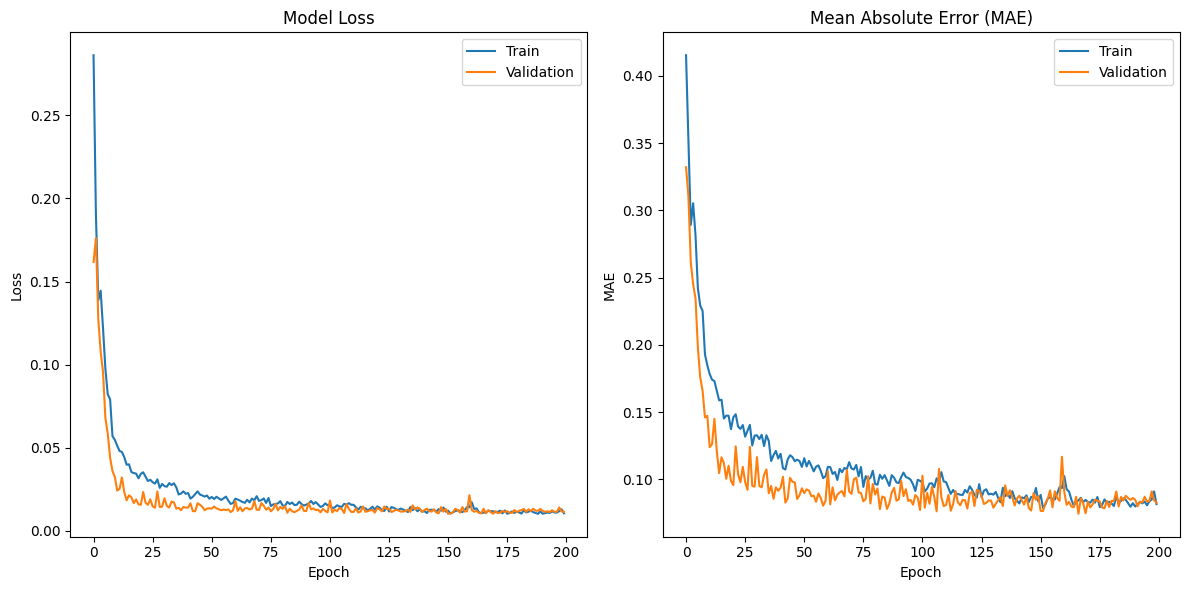

In [30]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [31]:
residuals1 = inverse_scaled_target - inverse_scaled_y_Predict1
residuals_final1 = inverse_scaled_y_final - inverse_scaled_y_pred_final1

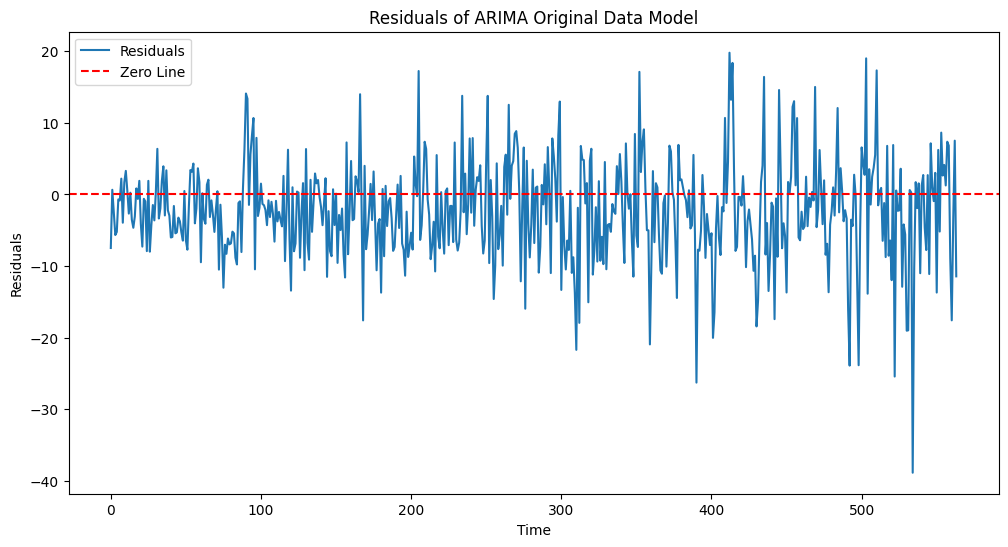

In [32]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

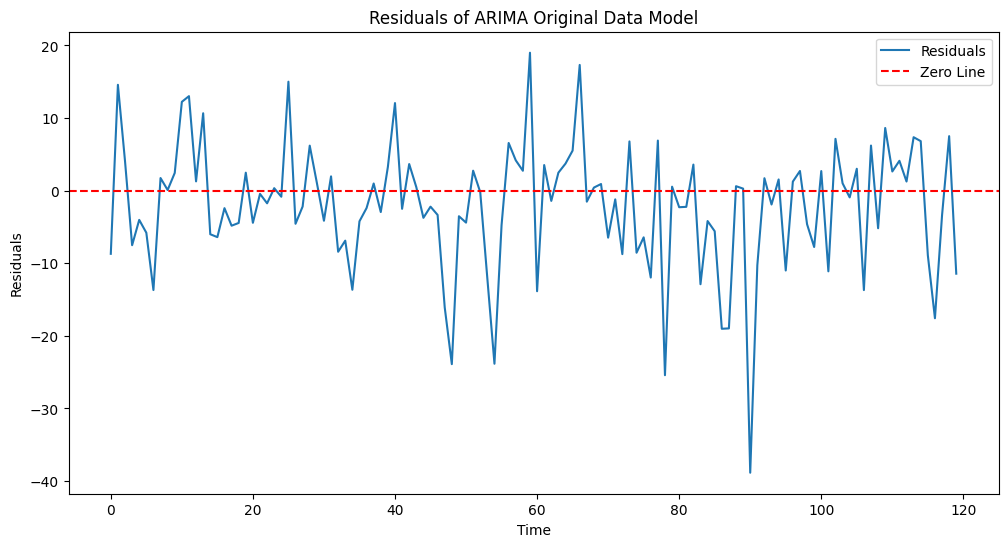

In [33]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [34]:
residuals2 = inverse_scaled_target - inverse_scaled_y_Predict2
residuals_final2 = inverse_scaled_y_final - inverse_scaled_y_pred_final2

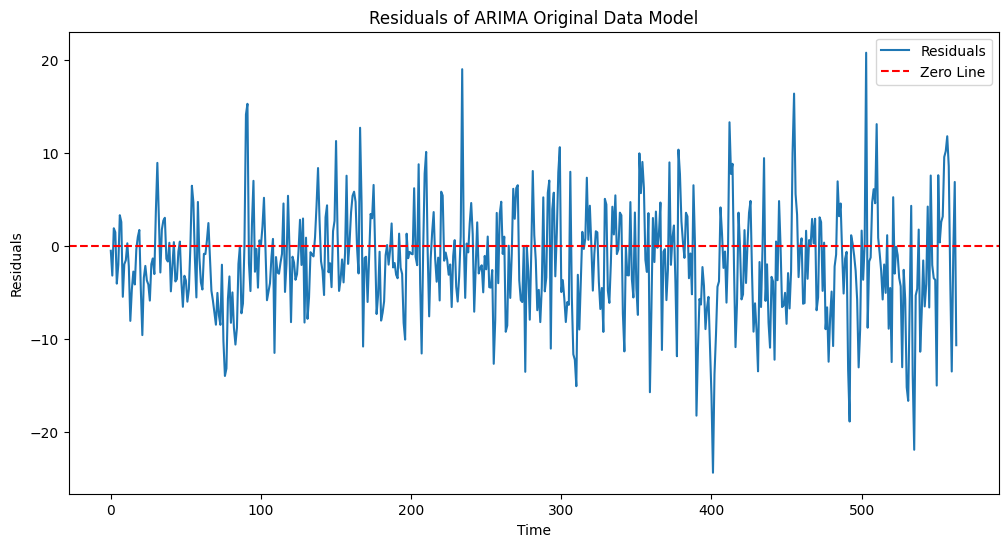

In [35]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

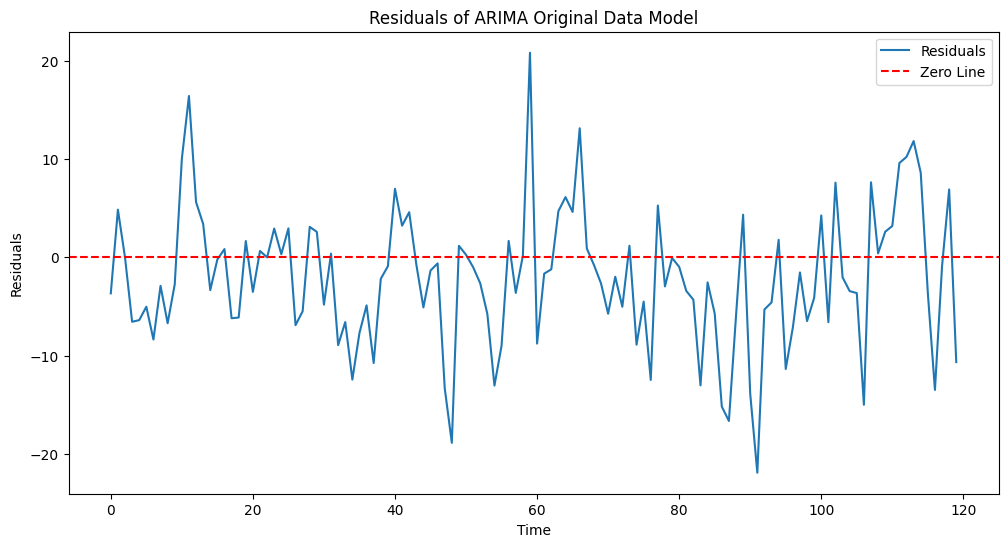

In [36]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [39]:
def residual_analysis(residuals):
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test (Normality):")
    print("Test Statistic:", stat)
    print("P-value:", p_value)
    if p_value > 0.05:
        print("The residuals appear to be normally distributed.")
    else:
        print("The residuals may not be normally distributed.")

    # Anderson-Darling Test for normality
    result = anderson(residuals)
    test_statistic = result.statistic
    critical_values = result.critical_values

    # Plot ACF and PACF on residuals
    plt.figure(figsize=(12, 6))
    acf_res = plot_acf(residuals, title='ACF of Residuals')
    pacf_res = plot_pacf(residuals, title='PACF of Residuals')
    plt.show()

    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

Shapiro-Wilk Test (Normality):
Test Statistic: 0.978893879480203
P-value: 2.870034666171926e-07
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

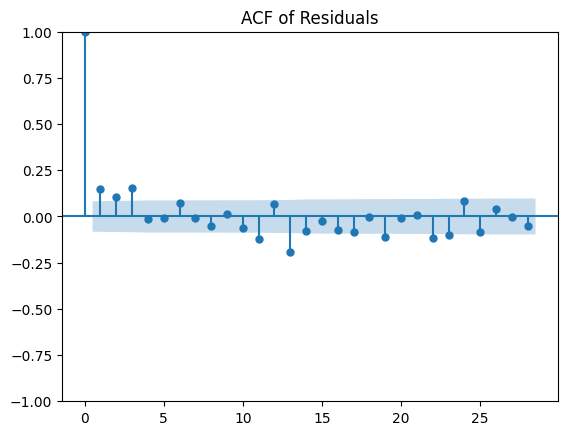

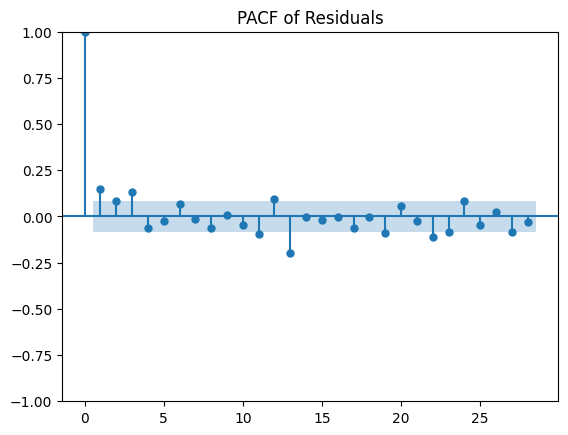

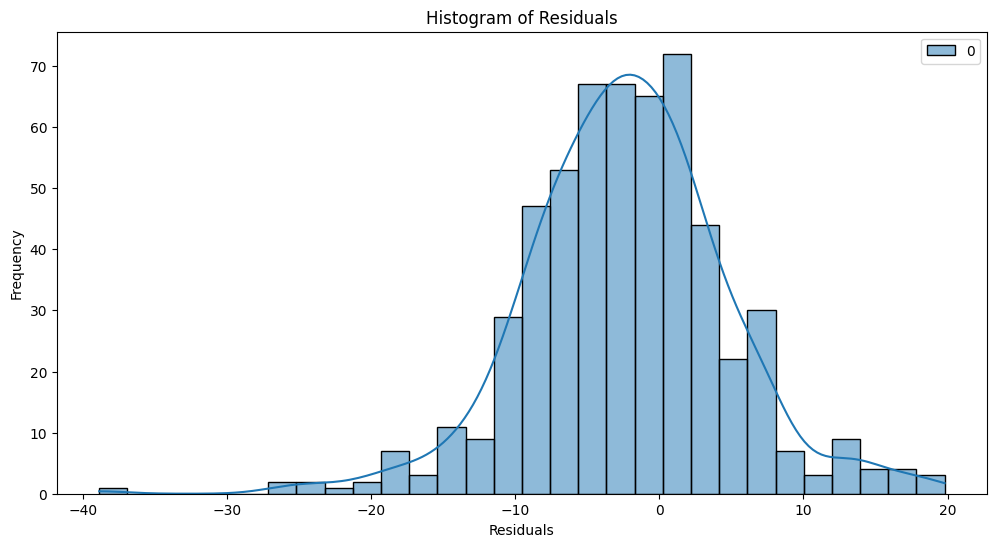

In [38]:
residual_analysis(residuals1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9569757554006093
P-value: 0.0007287879573537017
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

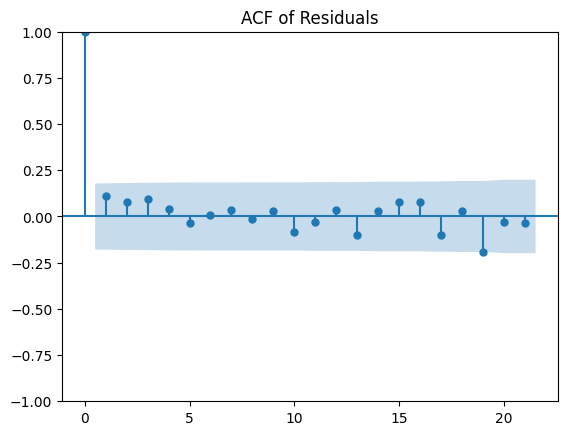

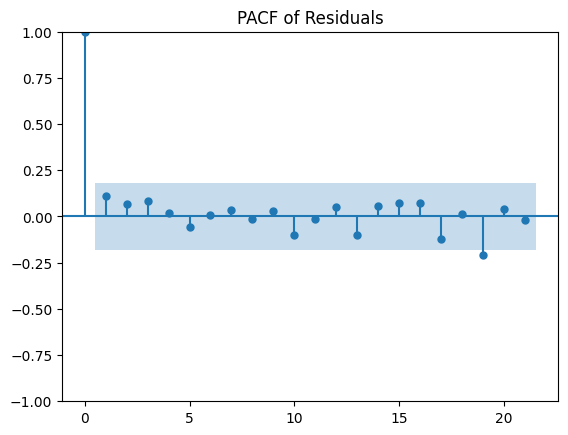

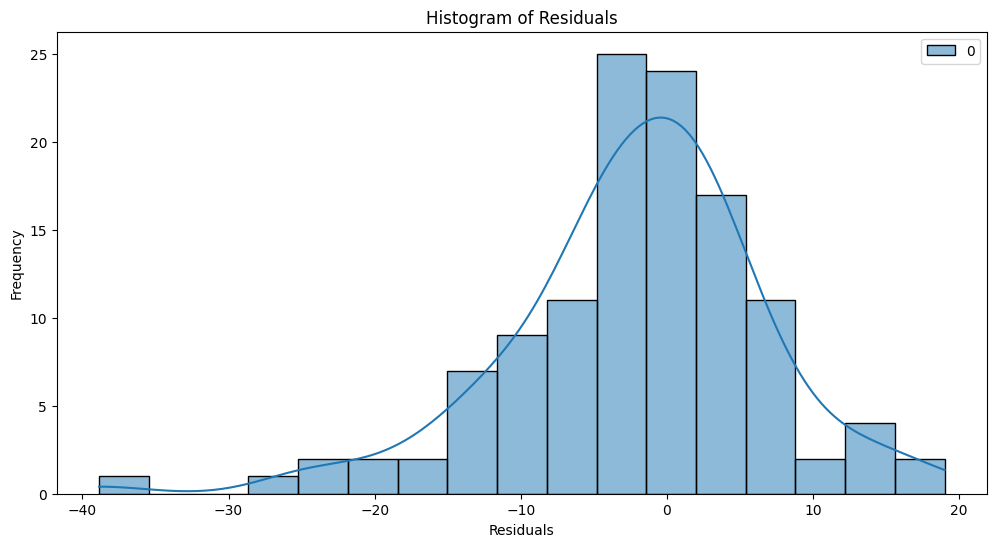

In [40]:
residual_analysis(residuals_final1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9890465768356173
P-value: 0.00031943180654836966
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

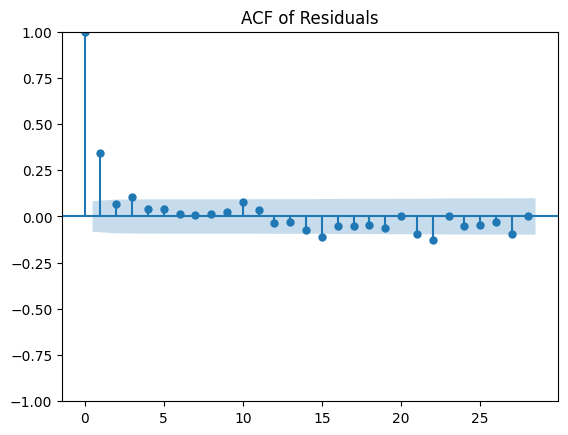

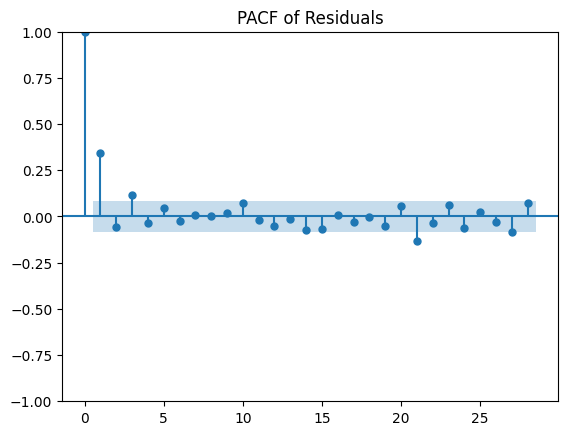

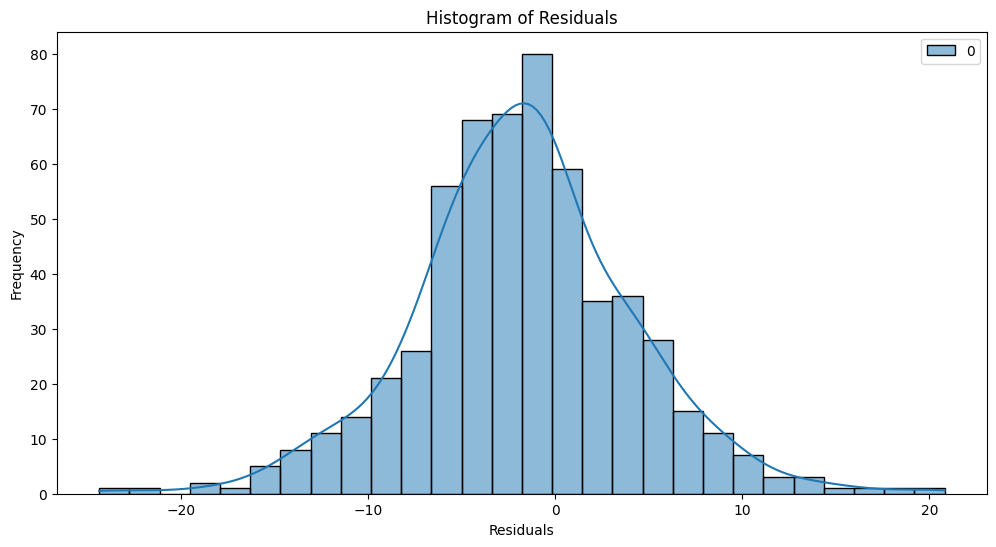

In [41]:
residual_analysis(residuals2)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9894303092775535
P-value: 0.48485403564847745
The residuals appear to be normally distributed.


<Figure size 1200x600 with 0 Axes>

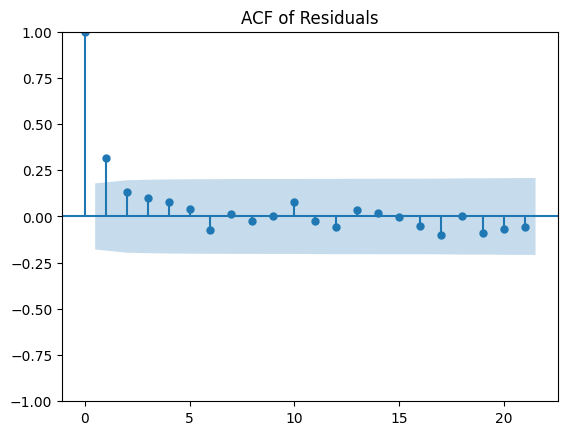

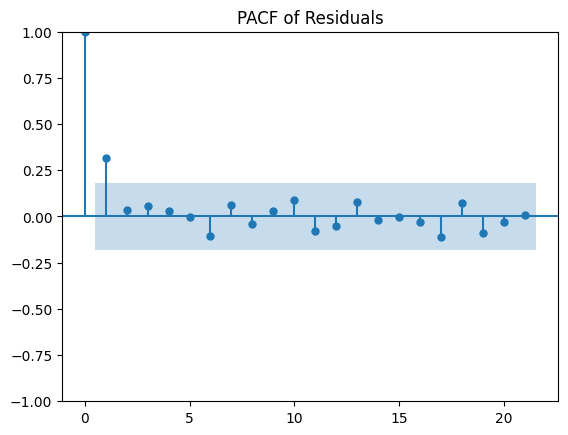

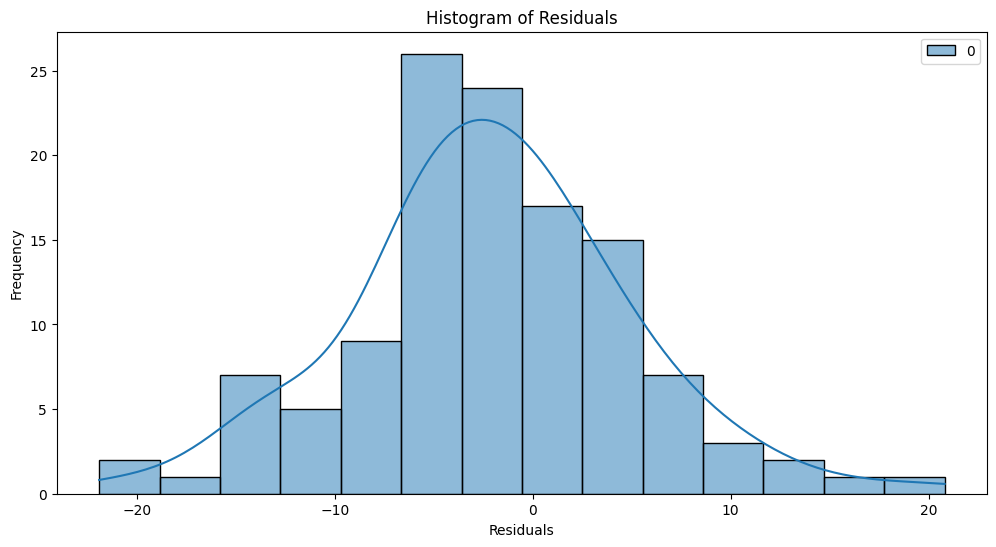

In [42]:
residual_analysis(residuals_final2)